# GPU accelerated solution using NVIDIA RAPIDS cudf and cuml
# Data loading, preprocessing and feature engineering takes less than 3min in GPU.

In [1]:
import pandas
import numpy as np
import cudf as pd
import cupy as cp

import glob
import os
import gc
import time

from joblib import Parallel, delayed

from sklearn import preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from scipy.optimize import minimize


import matplotlib.pyplot as plt 
import seaborn as sns
import numpy.matlib
from catboost import Pool, CatBoostRegressor
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import cuml
from cuml.neighbors import KNeighborsRegressor
from cuml import LinearRegression
from cuml import Ridge
from cuml.ensemble import RandomForestRegressor


path_submissions = '/'

target_name = 'target'
scores_folds = {}

def convert_to_32bit(df):
    for f in df.columns:
        if df[f].dtype == 'int64':
            df[f] = df[f].astype('int32')
        if df[f].dtype == 'float64':
            df[f] = df[f].astype('float32')
    return df

# Loading train and test sets

In [2]:
# data directory
data_dir = '../input/optiver-realized-volatility-prediction/'

train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')

train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)

train['is_train'] = 1
test['is_train'] = 0

train = convert_to_32bit(train)
test = convert_to_32bit(test)

print( train.shape )
print( test.shape )

(428932, 5)
(3, 4)


In [3]:
print(train.head(20))

    stock_id  time_id    target row_id  is_train
0          0        5  0.004136    0-5         1
1          0       11  0.001445   0-11         1
2          0       16  0.002168   0-16         1
3          0       31  0.002195   0-31         1
4          0       62  0.001747   0-62         1
5          0       72  0.004912   0-72         1
6          0       97  0.009388   0-97         1
7          0      103  0.004120  0-103         1
8          0      109  0.002182  0-109         1
9          0      123  0.002669  0-123         1
10         0      128  0.003702  0-128         1
11         0      146  0.005397  0-146         1
12         0      147  0.002751  0-147         1
13         0      152  0.003969  0-152         1
14         0      157  0.005525  0-157         1
15         0      159  0.002077  0-159         1
16         0      169  0.003365  0-169         1
17         0      207  0.007260  0-207         1
18         0      211  0.001707  0-211         1
19         0      21

In [4]:
print(test.head(20))

   stock_id  time_id row_id  is_train
0         0        4    0-4         0
1         0       32   0-32         0
2         0       34   0-34         0


# Checking how many stock_id there are in train and test

In [5]:
train_stock_ids = train['stock_id'].to_pandas().unique()
test_stock_ids = test['stock_id'].to_pandas().unique()
print( 'Sizes:', len(train_stock_ids), len(test_stock_ids) )
print( 'Train stocks:', train_stock_ids )
print( 'Test stocks:', test_stock_ids )

Sizes: 112 1
Train stocks: [  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  23  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  46  47  48  50  51  52  53  55  56  58  59  60
  61  62  63  64  66  67  68  69  70  72  73  74  75  76  77  78  80  81
  82  83  84  85  86  87  88  89  90  93  94  95  96  97  98  99 100 101
 102 103 104 105 107 108 109 110 111 112 113 114 115 116 118 119 120 122
 123 124 125 126]
Test stocks: [0]


In [6]:
# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df = convert_to_32bit(df)
    
    # Calculate Wap
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    df['wap3'] = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    df['wap4'] = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    
    # Calculate log returns
    df['log_return1'] = df['wap1'].log()
    df['log_return1'] = df['log_return1'] - df.groupby(['time_id'])['log_return1'].shift(1).reset_index(drop=True)

    df['log_return2'] = df['wap2'].log()
    df['log_return2'] = df['log_return2'] - df.groupby(['time_id'])['log_return2'].shift(1).reset_index(drop=True)

    df['log_return3'] = df['wap3'].log()
    df['log_return3'] = df['log_return3'] - df.groupby(['time_id'])['log_return3'].shift(1).reset_index(drop=True)

    df['log_return4'] = df['wap4'].log()
    df['log_return4'] = df['log_return4'] - df.groupby(['time_id'])['log_return4'].shift(1).reset_index(drop=True)
    
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    df['log_return1_sqr'] = df['log_return1'] ** 2
    df['log_return2_sqr'] = df['log_return2'] ** 2
    df['log_return3_sqr'] = df['log_return3'] ** 2
    df['log_return4_sqr'] = df['log_return4'] ** 2
    
    df['momentum'] = ((df['wap1']-df['bid_price1']) / (df['ask_price1']-df['bid_price1']))*2 - 1
    df['momentum_unsigned'] = np.abs(df['momentum'])   
    
    df['volume_momentum'] = ((df['bid_size1']+df['bid_size2']) / (df['bid_size1']+df['bid_size2']+df['ask_size1']+df['ask_size2']))*2 - 1
    df['volume_momentum_unsigned'] = np.abs(df['volume_momentum'])
    
    # Dict for aggregations
    create_feature_dict = {
        'wap1': ['sum', 'std', 'min','max'],
        'wap2': ['sum', 'std', 'min','max'],
        'wap3': ['sum', 'std', 'min','max'],
        'wap4': ['sum', 'std', 'min','max'],
        'log_return1_sqr': ['sum', 'std', 'min','max'],
        'log_return2_sqr': ['sum', 'std', 'min','max'],
        'log_return3_sqr': ['sum', 'std', 'min','max'],
        'log_return4_sqr': ['sum', 'std', 'min','max'],
        'wap_balance': ['sum', 'mean', 'min','max'],
        'price_spread':['sum', 'mean', 'min','max'],
        'price_spread2':['sum', 'mean', 'min','max'],
        'bid_spread':['sum', 'mean', 'min','max'],
        'ask_spread':['sum', 'mean', 'min','max'],
        'total_volume':['sum', 'mean', 'min','max'],
        'volume_imbalance':['sum', 'mean', 'min','max'],
        "bid_ask_spread":['sum',  'mean', 'min','max'],
        'momentum':['sum','std'],
        'momentum_unsigned':['sum','std'],
        'volume_momentum':['sum','std'],
        'volume_momentum_unsigned':['sum','std'],
    }
    create_feature_dict_time = {
        'log_return1_sqr': ['sum', 'std', 'min','max'],
        'log_return2_sqr': ['sum', 'std', 'min','max'],
        'log_return3_sqr': ['sum', 'std', 'min','max'],
        'log_return4_sqr': ['sum', 'std', 'min','max'],
    }
    
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        if add_suffix:
            df_feature.columns = [col + '_' + str(seconds_in_bucket) for col in df_feature.columns]
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop tmp columns
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['stock_id'] = str(stock_id) + '-'

    df_feature['row_id'] = df_feature['stock_id'] + df_feature['time_id_'].astype(str)
    
    return df_feature

In [7]:
%%time

def transform(df, groupby='time_id', feat='price', agg='mean' ):
    return df.merge( 
        df.groupby(groupby)[feat].agg(agg).reset_index().rename({feat:feat+'_'+agg}, axis=1),
        on=groupby,
        how='left' 
    )

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df = convert_to_32bit(df)
    
    df['log_return'] = df['price'].log()
    df['log_return'] = df['log_return'] - df.groupby(['time_id'])['log_return'].shift(1).reset_index(drop=True)
    df['log_return_sqr'] = df['log_return'] ** 2
    
    df['amount']=df['price']*df['size']
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return_sqr': ['sum', 'std','max', 'min'],
        'seconds_in_bucket':['nunique','std', 'mean','max', 'min'],
        'size':['sum', 'nunique','std','max', 'min'],
        'order_count':['sum','nunique','max','min','std'],
        'amount':['sum','std','max','min'],
    }
    create_feature_dict_time = {
        'log_return_sqr': ['sum', 'std','max','min'],
        'seconds_in_bucket':['nunique'],
        'size':['sum','mean','std','min','max'],
        'order_count':['sum','mean','std','min','max'],
    }
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict,seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature.columns = [col + '_' + str(seconds_in_bucket) for col in df_feature.columns]
        return df_feature

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)
    df = df.sort_values(['time_id','seconds_in_bucket']).reset_index(drop=True)
    
    df = transform(df, groupby='time_id', feat='price', agg='mean' )
    df = transform(df, groupby='time_id', feat='price', agg='sum' )
    df = transform(df, groupby='time_id', feat='size', agg='mean' )
    df['price_dif'] = ((df['price'] - df.groupby(['time_id'])['price'].shift(1).reset_index(drop=True)) / df['price']).fillna(0.)
    df['tendencyV'] = df['size'] * df['price_dif']
    df['f_max'] = 1 * (df['price'] >= df['price_mean'])
    df['f_min'] = 1 * (df['price'] < df['price_mean'])
    df['df_max'] = 1 * (df['price_dif'] >= 0)
    df['df_min'] = 1 * (df['price_dif'] < 0)
    df['abs_dif'] = (df['price'] - df['price_mean']).abs()
    df['price_sqr'] = df['price']**2
    df['size_dif'] = (df['size'] - df['size_mean']).abs()
    df['size_sqr'] = df['size']**2
    df['iqr_p25'] = df.groupby(['time_id'])['price'].quantile(0.15).reset_index(drop=True)
    df['iqr_p75'] = df.groupby(['time_id'])['price'].quantile(0.85).reset_index(drop=True)
    df['iqr_p_v25'] = df.groupby(['time_id'])['size'].quantile(0.15).reset_index(drop=True)
    df['iqr_p_v75'] = df.groupby(['time_id'])['size'].quantile(0.85).reset_index(drop=True)

    dt = df.groupby('time_id')[['tendencyV','price','price_dif','f_max','f_min','df_max','df_min','abs_dif','price_sqr','size_dif','size_sqr','iqr_p25','iqr_p75','iqr_p_v25','iqr_p_v75']].agg(
        {
            'tendencyV':['sum','std','max', 'min'],
            'price':['mean','std','max', 'min'],
            'price_dif':['mean','std','max', 'min'],
            'f_max':['mean','std','max', 'min'],
            'f_min':['mean','std','max', 'min'],
            'df_max':['mean','std','max', 'min'],
            'df_min':['mean','std','max', 'min'],
            'abs_dif':['median','std','max', 'min'],
            'price_sqr':['sum','std','max', 'min'],
            'size_dif':['median','std','max', 'min'],
            'size_sqr':['sum','std','max', 'min'],
            'iqr_p25':['mean','std','max', 'min'],
            'iqr_p75':['mean','std','max', 'min'],
            'iqr_p_v25':['mean','std','max', 'min'],
            'iqr_p_v75':['mean','std','max', 'min'],
        }
    )
    dt.columns = [i+'_'+j for i, j in dt.columns] 
    df_feature = df_feature.merge(dt, left_on='time_id_', right_index=True, how='left')
    
    # Merge all
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    
    # Drop tmp columns
    df_feature = df_feature.sort_values(['time_id_' ]).reset_index(drop=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['stock_id'] = str(stock_id) + '-'
    df_feature['row_id'] = df_feature['stock_id'] + df_feature['time_id_'].astype(str)
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200', 'time_id_','time_id__100','stock_id'], axis = 1, inplace = True)

    fnames = ['trade_' + f for f in df_feature.columns]
    fnames[-1] = 'row_id'
    df_feature.columns = fnames

    return df_feature

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


# Process all train .parquet files. Create features using cudf (GPU)
# Note cudf speed to load and apply all feature engineering in all train set stocks.

In [8]:
%%time
DF_TRAIN = []
for stock_id in tqdm(train_stock_ids):
    df_tmp = pd.merge( 
        book_preprocessor(data_dir + "book_train.parquet/stock_id=" + str(stock_id)),
        trade_preprocessor(data_dir + "trade_train.parquet/stock_id=" + str(stock_id)),
        on = 'row_id',
        how = 'left'
    )
    df_tmp['stock_id'] = stock_id
    df_tmp = convert_to_32bit(df_tmp) # to save memory
    #df_tmp.to_parquet( 'train_parquet/'+str(stock_id)+'.parquet' )
    DF_TRAIN.append(df_tmp)

# Concatenate all stock_id in the same dataframe
DF_TRAIN = pd.concat(DF_TRAIN, ignore_index=True )
_ = gc.collect()

# Flag to filter train/test rows
DF_TRAIN['is_test'] = 0
DF_TRAIN.shape

100%|██████████| 112/112 [02:36<00:00,  1.40s/it]


CPU times: user 1min 35s, sys: 27.9 s, total: 2min 3s
Wall time: 2min 38s


(428932, 314)

# Process all test .parquet files. Create features using cudf (GPU)

In [9]:
%%time
DF_TEST = []
for stock_id in tqdm(test_stock_ids):
    df_tmp = pd.merge( 
        book_preprocessor(data_dir + "book_test.parquet/stock_id=" + str(stock_id)),
        trade_preprocessor(data_dir + "trade_test.parquet/stock_id=" + str(stock_id)),
        on = 'row_id',
        how = 'left'
    )
    df_tmp['stock_id'] = stock_id
    df_tmp = convert_to_32bit(df_tmp) # to save memory
    #df_tmp.to_parquet( 'test_parquet/'+str(stock_id)+'.parquet' )
    DF_TEST.append(df_tmp)
    
# Concatenate all stock_id in the same dataframe
DF_TEST = pd.concat(DF_TEST, ignore_index=True )
_ = gc.collect()

# Flag to filter train/test rows
DF_TEST['is_test'] = 1
DF_TEST.shape

100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

CPU times: user 712 ms, sys: 8.18 ms, total: 720 ms
Wall time: 734 ms


(1, 314)

In [10]:
TRAIN = pd.concat( [DF_TRAIN, DF_TEST] ).sort_values(['stock_id','time_id_']).reset_index(drop=True)

del DF_TRAIN, DF_TEST
_ = gc.collect()
TRAIN.shape

(428933, 314)

In [11]:
%%time

def get_time_stock(df_):
    vol_cols = ['log_return1_sqr_sum_500', 'log_return2_sqr_sum_500', 'log_return3_sqr_sum_500', 'log_return4_sqr_sum_500', 'trade_log_return_sqr_sum', 'trade_log_return_sqr_std', 'trade_seconds_in_bucket_nunique' ]

    df = df_.copy()
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    df_stock_id.columns = ['_'.join(col) + '_stock' for col in df_stock_id.columns]

    df_time_id = df.groupby(['time_id_'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    df_time_id.columns = ['_'.join(col)+ '_time' for col in df_time_id.columns]
    
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id_'], right_on = ['time_id___time'])
    df.drop(['stock_id__stock', 'time_id___time'], axis = 1, inplace = True)
    return df

TRAIN_ = get_time_stock(TRAIN)
TRAIN_.drop(['stock_id','time_id_'], axis = 1, inplace = True)
print(TRAIN_.shape)
print(TRAIN_.head())

(428933, 368)
     wap1_sum  wap1_std  wap1_min  wap1_max    wap2_sum  wap2_std  wap2_min  \
0  491.059692  0.000437  0.998868  1.000914  491.068878  0.000477  0.998870   
1  331.272003  0.000964  0.999005  1.003642  331.323883  0.001018  0.998921   
2  298.553101  0.000947  0.996610  1.000573  298.572296  0.001034  0.996466   
3  582.350342  0.001520  0.993641  0.999571  582.324402  0.001549  0.993641   
4  287.226196  0.000677  0.995888  0.999384  287.299713  0.000940  0.994704   

   wap2_max    wap3_sum  wap3_std  ...  trade_log_return_sqr_sum_max_time  \
0  1.001132  491.081268  0.000396  ...                           0.000034   
1  1.004022  331.344757  0.001013  ...                           0.000022   
2  1.000570  298.502289  0.001103  ...                           0.000019   
3  0.999786  582.388977  0.001496  ...                           0.000027   
4  1.000074  286.961395  0.000657  ...                           0.000028   

   trade_log_return_sqr_sum_min_time  trade_log_

In [12]:
train = train.merge(TRAIN_, on='row_id', how='left' )
test  = test.merge(TRAIN_, on='row_id', how='left' )

del TRAIN_, TRAIN
_ = gc.collect()

train.shape, test.shape

((428932, 372), (3, 371))

In [13]:
train.head()

,stock_id,time_id,target,row_id,is_train,wap1_sum,wap1_std,wap1_min,wap1_max,wap2_sum,...,trade_log_return_sqr_sum_max_time,trade_log_return_sqr_sum_min_time,trade_log_return_sqr_std_mean_time,trade_log_return_sqr_std_std_time,trade_log_return_sqr_std_max_time,trade_log_return_sqr_std_min_time,trade_seconds_in_bucket_nunique_mean_time,trade_seconds_in_bucket_nunique_std_time,trade_seconds_in_bucket_nunique_max_time,trade_seconds_in_bucket_nunique_min_time
0,0,10604,0.003078,0-10604,1,240.041046,0.000823,0.998679,1.001850,240.017700,...,0.000077,7.867974e-07,1.652909e-07,1.958228e-07,0.000001,3.408399e-09,90.589286,79.341269,439,11
1,0,10703,0.004344,0-10703,1,259.323792,0.001001,0.995239,0.999452,259.297424,...,0.000029,9.603019e-07,1.824191e-07,3.604568e-07,0.000004,6.608633e-09,71.312500,58.376385,325,4
2,0,10661,0.002892,0-10661,1,146.198929,0.000417,1.000542,1.002288,146.166885,...,0.000147,4.017960e-07,1.537688e-07,6.347032e-07,0.000007,4.833834e-09,60.250000,46.428381,293,7
3,0,10765,0.006553,0-10765,1,195.584579,0.002373,1.009551,1.020173,195.636261,...,0.000111,5.171611e-06,7.098751e-07,6.771278e-07,0.000003,1.434562e-08,139.747748,123.167843,576,9
4,0,10608,0.003279,0-10608,1,284.762238,0.002616,0.991918,1.000521,284.686005,...,0.000030,1.328192e-06,2.206635e-07,2.365471e-07,0.000001,1.457424e-08,98.428571,74.786870,435,14


# Now time to calculate correlation between all stock. The best way is using a correlation matrix, so first pivot all target variables by stock_id, then just calculate the correlation matrix.
# To Find correlated stocks use Kmeans algorithm on the correlation matrix. This procedure is a bit leak because it not being processed using crossvalidation, but it won't leak much since only 6 clusters are being calculated.

In [14]:
%%time
train_p = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
train_p = train_p.pivot(index='time_id', columns=['stock_id'], values=['target']).fillna(0.)
corr = train_p.corr()

km = cuml.KMeans(n_clusters=6, max_iter=2000, n_init=5).fit(corr)
df = pd.DataFrame( {'stock_id': [ f[1] for f in corr.columns ], 'cluster': km.labels_} )
df = convert_to_32bit(df)

train = train.merge(df, on='stock_id', how='left')
test = test.merge(df, on='stock_id', how='left')


del train_p, df, corr, km
_ = gc.collect()

# Clusters found
train.groupby('cluster')['time_id'].agg('count')

CPU times: user 3.46 s, sys: 160 ms, total: 3.62 s
Wall time: 4.17 s


cluster
5     34455
3    126389
0    122559
2     99580
4     34469
1     11480
Name: time_id, dtype: int32

In [15]:
matTrain = []
matTest = []

# 6 clusters
for ind in range(train.cluster.max()+1):
    print(ind)
    newDf = train.loc[train['cluster']==ind].copy()
    newDf = newDf.groupby(['time_id']).agg('mean')
    newDf.loc[:,'stock_id'] = 127+ind
    matTrain.append ( newDf )
    
    newDf = test.loc[test['cluster']==ind].copy()
    newDf = newDf.groupby(['time_id']).agg('mean')
    newDf.loc[:,'stock_id'] = 127+ind
    matTest.append ( newDf )
    
matTrain = pd.concat(matTrain).reset_index()
matTrain.drop(columns=['target'],inplace=True)

matTest = pd.concat(matTest).reset_index()

matTrain.shape, matTest.shape

0
1
2
3
4
5


((22980, 371), (3, 371))

In [16]:
matTest = pd.concat([matTest , matTrain.loc[matTrain.time_id==5]])
matTrain = matTrain.pivot(index='time_id', columns='stock_id')
matTrain.columns = [x[0]+'_stock'+str(int(x[1])) for x in matTrain.columns]
matTrain.reset_index(inplace=True)

matTest = matTest.pivot(index='time_id', columns='stock_id')
matTest.columns = [x[0]+'_stock'+str(int(x[1])) for x in matTest.columns]
matTest.reset_index(inplace=True)

matTrain.shape, matTest.shape

((3830, 2215), (4, 2215))

In [17]:
kfeatures = [
    'time_id',
        
    'wap1_sum_stock127',
    'wap1_sum_stock128',     
    'wap1_sum_stock129',
    'wap1_sum_stock130',     
    'wap1_sum_stock131',
    'wap1_sum_stock132',
        
    'wap2_sum_stock127',
    'wap2_sum_stock128',     
    'wap2_sum_stock129',
    'wap2_sum_stock130',     
    'wap2_sum_stock131',
    'wap2_sum_stock132',
        
    'wap3_sum_stock127',
    'wap3_sum_stock128',     
    'wap3_sum_stock129',
    'wap3_sum_stock130',     
    'wap3_sum_stock131',
    'wap3_sum_stock132',
        
    'wap4_sum_stock127',
    'wap4_sum_stock128',     
    'wap4_sum_stock129',
    'wap4_sum_stock130',     
    'wap4_sum_stock131',
    'wap4_sum_stock132',
    
    'log_return1_sqr_sum_stock127',
    'log_return1_sqr_sum_stock128',     
    'log_return1_sqr_sum_stock129',
    'log_return1_sqr_sum_stock130',     
    'log_return1_sqr_sum_stock131',
    'log_return1_sqr_sum_stock132',

    'log_return2_sqr_sum_stock127',
    'log_return2_sqr_sum_stock128',     
    'log_return2_sqr_sum_stock129',
    'log_return2_sqr_sum_stock130',     
    'log_return2_sqr_sum_stock131',
    'log_return2_sqr_sum_stock132',

    'log_return3_sqr_sum_stock127',
    'log_return3_sqr_sum_stock128',     
    'log_return3_sqr_sum_stock129',
    'log_return3_sqr_sum_stock130',     
    'log_return3_sqr_sum_stock131',
    'log_return3_sqr_sum_stock132',

    'log_return4_sqr_sum_stock127',
    'log_return4_sqr_sum_stock128',     
    'log_return4_sqr_sum_stock129',
    'log_return4_sqr_sum_stock130',     
    'log_return4_sqr_sum_stock131',
    'log_return4_sqr_sum_stock132',
    
    'total_volume_sum_stock127',
    'total_volume_sum_stock128', 
    'total_volume_sum_stock129',
    'total_volume_sum_stock130', 
    'total_volume_sum_stock131',
    'total_volume_sum_stock132',
    
    'trade_size_sum_stock127',
    'trade_size_sum_stock128', 
    'trade_size_sum_stock129',
    'trade_size_sum_stock130', 
    'trade_size_sum_stock131',
    'trade_size_sum_stock132',
    
    'trade_order_count_sum_stock127',
    'trade_order_count_sum_stock128',
    'trade_order_count_sum_stock129',
    'trade_order_count_sum_stock130',
    'trade_order_count_sum_stock131',      
    'trade_order_count_sum_stock132',
    
    'price_spread_sum_stock127',
    'price_spread_sum_stock128',
    'price_spread_sum_stock129',
    'price_spread_sum_stock130',
    'price_spread_sum_stock131',   
    'price_spread_sum_stock132',
    
    'bid_spread_sum_stock127',
    'bid_spread_sum_stock128',
    'bid_spread_sum_stock129',
    'bid_spread_sum_stock130',
    'bid_spread_sum_stock131',
    'bid_spread_sum_stock132',
    
    'ask_spread_sum_stock127',
    'ask_spread_sum_stock128',
    'ask_spread_sum_stock129',
    'ask_spread_sum_stock130',
    'ask_spread_sum_stock131',   
    'ask_spread_sum_stock132',
    
    'volume_imbalance_sum_stock127',
    'volume_imbalance_sum_stock128',
    'volume_imbalance_sum_stock129',
    'volume_imbalance_sum_stock130',
    'volume_imbalance_sum_stock131',       
    'volume_imbalance_sum_stock132',
    
    'bid_ask_spread_sum_stock127',
    'bid_ask_spread_sum_stock128',
    'bid_ask_spread_sum_stock129',
    'bid_ask_spread_sum_stock130',
    'bid_ask_spread_sum_stock131',
    'bid_ask_spread_sum_stock132',
    
    'momentum_sum_stock127',
    'momentum_sum_stock128',
    'momentum_sum_stock129',
    'momentum_sum_stock130',
    'momentum_sum_stock131',
    'momentum_sum_stock132',
    
    'momentum_unsigned_sum_stock127',
    'momentum_unsigned_sum_stock128',
    'momentum_unsigned_sum_stock129',
    'momentum_unsigned_sum_stock130',
    'momentum_unsigned_sum_stock131',
    'momentum_unsigned_sum_stock132',
    
    'volume_momentum_sum_stock127',
    'volume_momentum_sum_stock128',
    'volume_momentum_sum_stock129',
    'volume_momentum_sum_stock130',
    'volume_momentum_sum_stock131',
    'volume_momentum_sum_stock132',
    
    
    'volume_momentum_unsigned_sum_stock127',
    'volume_momentum_unsigned_sum_stock128',
    'volume_momentum_unsigned_sum_stock129',
    'volume_momentum_unsigned_sum_stock130',
    'volume_momentum_unsigned_sum_stock131',
    'volume_momentum_unsigned_sum_stock132',
    
    
]
matTrain = convert_to_32bit(matTrain)
matTest = convert_to_32bit(matTest)

train = pd.merge(train,matTrain[kfeatures],how='left',on='time_id')
test = pd.merge(test,matTest[kfeatures],how='left',on='time_id')
_ = gc.collect()

print( train.shape, test.shape )

(428932, 493) (3, 492)


In [18]:
# train=train[~(train["stock_id"]==31)].reset_index(drop=True)
# _= gc.collect()

train = convert_to_32bit(train)
test  = convert_to_32bit(test)
_= gc.collect()

train.shape, test.shape

((428932, 493), (3, 492))

In [19]:
y_target = train.target.to_pandas() #need to be numpy or pandas for sklearn 
time_id = train.time_id.to_pandas()
NFOLD = 5

def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Target min and max values
np.min(y_target), np.max(y_target)

(0.00010526300320634618, 0.07032062113285065)

# XGBoost GPU

In [20]:
xgbtime = time.time()

# Define the custom metric to optimize
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    err = rmspe(labels, preds)
    return 'rmspe', err

def train_and_evaluate_xgb(train, test, params, colNames):
    # Sample weight
    train['target_sqr'] = 1. / (train['target'] ** 1.55 + 9e-7)    

    dtest = xgb.DMatrix(test[colNames])

    y_train = np.zeros(len(train))
    y_test = np.zeros(len(test))

    kf = GroupKFold(n_splits=NFOLD)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)
        dtrain = xgb.DMatrix(train.loc[train_idx, colNames], train.loc[train_idx, 'target'], weight=train.loc[train_idx, 'target_sqr'])
        dvalid = xgb.DMatrix(train.loc[valid_idx, colNames], train.loc[valid_idx, 'target'])
        model = xgb.train(
            params,
            dtrain,
            3000,
            #[(dtrain, "train"), (dvalid, "valid")],
            [(dvalid, "valid")],
            verbose_eval=250,
            early_stopping_rounds=50,
            feval=evalerror,
        )
        y_train[valid_idx] = np.clip(model.predict(dvalid), 2e-4, 0.072)
        y_test += np.clip((model.predict(dtest)), 2e-4, 0.072)
        print( 'Rmspe Fold:', rmspe(y_target[valid_idx], y_train[valid_idx]) )
    y_test /= NFOLD
    
    print( 'XGBoost Rmspe CV:', rmspe(y_target, y_train) )
    print( pandas.DataFrame.from_dict( model.get_score(), orient='index').sort_values(0, ascending=False).head(20) )
    print()
    
    del model, dtest, dtrain, dvalid
    _ = gc.collect()
    
    return y_train, y_test


colNames = [col for col in list(train.columns) if col not in {'is_train', 'time_id', 'target', 'row_id', 'target_sqr', 'is_train'}]
colNames = [col for col in colNames if col.find('min')<0 ]
params = {
        "subsample": 0.60,
        "colsample_bytree": 0.40,
        "max_depth": 6,
        "learning_rate": 0.02,
        "objective": "reg:squarederror",
        'disable_default_eval_metric': 1, # <- necessary for XGBoost to earlystop by Rmspe and not the default rmse
        "nthread": -1,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "max_bin": 128, 
        'min_child_weight': 2,
        'reg_lambda': 0.001,
        'reg_alpha': 0.01, 
        'seed' : 2021,
    }
y_train1a, y_test1a = train_and_evaluate_xgb(train, test, params, colNames)


colNames = [col for col in list(train.columns) if col not in {'is_train', 'time_id', 'target', 'row_id', 'target_sqr', 'is_train'}]
colNames = [col for col in colNames if col.find('max')<0 ]
params = {
        "subsample": 0.85,
        "colsample_bytree": 0.25,
        "max_depth": 7,
        "learning_rate": 0.02,
        "objective": "reg:squarederror",
        'disable_default_eval_metric': 1, # <- necessary for XGBoost to earlystop by Rmspe and not the default rmse
        "nthread": -1,
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "max_bin": 128, 
        'min_child_weight': 2,
        'reg_lambda': 0.001,
        'reg_alpha': 0.01, 
        'seed' : 2022,
    }
y_train1b, y_test1b = train_and_evaluate_xgb(train, test, params, colNames)


y_train1 = 0.75*y_train1a + 0.25*y_train1b
y_test1  = 0.75*y_test1a  + 0.25*y_test1b


xgbtime = time.time() - xgbtime

print( 'XGBoost Rmspe CV:', rmspe(y_target, y_train1), 'time: ', int(xgbtime), 's', y_test1[:3] )

Fold: 0
[0]	valid-rmspe:225.17076
[250]	valid-rmspe:1.47747
[500]	valid-rmspe:0.22113
[666]	valid-rmspe:0.21999
Rmspe Fold: 0.21999807073727753
Fold: 1
[0]	valid-rmspe:227.78713
[250]	valid-rmspe:1.50744
[500]	valid-rmspe:0.23672
[706]	valid-rmspe:0.23444
Rmspe Fold: 0.23441972697732233
Fold: 2
[0]	valid-rmspe:227.22092
[250]	valid-rmspe:1.50238
[500]	valid-rmspe:0.22338
[616]	valid-rmspe:0.22265
Rmspe Fold: 0.22265437605879165
Fold: 3
[0]	valid-rmspe:226.14059
[250]	valid-rmspe:1.49489
[500]	valid-rmspe:0.22079
[674]	valid-rmspe:0.21989
Rmspe Fold: 0.21989302031611016
Fold: 4
[0]	valid-rmspe:223.47002
[250]	valid-rmspe:1.47630
[500]	valid-rmspe:0.21900
[656]	valid-rmspe:0.21861
Rmspe Fold: 0.21860939317050576
XGBoost Rmspe CV: 0.2231904035916705
                                         0
log_return1_sqr_sum_500_mean_stock     558
trade_log_return_sqr_sum_mean_stock    545
stock_id                               536
log_return1_sqr_sum                    528
wap1_sum                    

In [21]:
catbtime = time.time()

def train_and_evaluate_catb(train, test, params):

    # Sample weight
    train['target_sqr'] = 1. / (train['target'] ** 1.75 + 1e-6)

    colNames = [col for col in list(train.columns) if col not in {'is_train', 'time_id', 'target', 'row_id', 'target_sqr', 'is_train'}]

    y_train = np.zeros(len(train))
    y_test = np.zeros(len(test))

    kf = GroupKFold(n_splits=NFOLD)
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)

        model = CatBoostRegressor(
            iterations=3000,
            learning_rate=0.05,
            depth=7,
            loss_function='RMSE',
            #l2_leaf_reg = 0.001,
            #random_strength = 0.5,
            #bagging_temperature = 1.0,
            task_type="GPU",
            random_seed = 2021,
        )        
        model.fit(
            X=train.loc[train_idx, colNames].to_pandas(), y=train.loc[train_idx, 'target'].to_pandas(),
            sample_weight = train.loc[train_idx, 'target_sqr'].to_pandas(),
            eval_set = (train.loc[valid_idx, colNames].to_pandas(), train.loc[valid_idx, 'target'].to_pandas(),),
            early_stopping_rounds = 20,
            cat_features = [0],
            verbose=False)

        y_train[valid_idx] = np.clip(model.predict(train.loc[valid_idx, colNames].to_pandas()), 2e-4, 0.072)
        y_test += np.clip((model.predict(test[colNames].to_pandas())), 2e-4, 0.072)
        print( 'Catboost Rmspe Fold:', rmspe(y_target[valid_idx], y_train[valid_idx]) )        
        print()
    y_test /= NFOLD
    return y_train, y_test


y_train2, y_test2 = train_and_evaluate_catb(train, test, params)
_= gc.collect()
catbtime = time.time() - catbtime
     
print( 'Catboost Rmspe CV:', rmspe(y_target, y_train2), 'time: ', int(catbtime), 's', y_test2[:3]  )

Fold: 0
Catboost Rmspe Fold: 0.2218116038440418

Fold: 1
Catboost Rmspe Fold: 0.23428544233093865

Fold: 2
Catboost Rmspe Fold: 0.22026244737534587

Fold: 3
Catboost Rmspe Fold: 0.21740859558491046

Fold: 4
Catboost Rmspe Fold: 0.2149288303269312

Catboost Rmspe CV: 0.22184073898626325 time:  385 s [0.00162711 0.001964   0.001964  ]


# LightGBM GPU

Fold: 0
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.000506001	training's RMSPE: 0.216485	valid_1's rmse: 0.00139147	valid_1's RMSPE: 0.223908
[200]	training's rmse: 0.000481151	training's RMSPE: 0.20341	valid_1's rmse: 0.00133889	valid_1's RMSPE: 0.219213
[300]	training's rmse: 0.000466367	training's RMSPE: 0.196176	valid_1's rmse: 0.00131556	valid_1's RMSPE: 0.21767
[400]	training's rmse: 0.00045586	training's RMSPE: 0.190956	valid_1's rmse: 0.00129872	valid_1's RMSPE: 0.216992
[500]	training's rmse: 0.000447594	training's RMSPE: 0.186824	valid_1's rmse: 0.00128797	valid_1's RMSPE: 0.216473
[600]	training's rmse: 0.000441103	training's RMSPE: 0.183586	valid_1's rmse: 0.00128	valid_1's RMSPE: 0.216321
Early stopping, best iteration is:
[670]	training's rmse: 0.00043707	training's RMSPE: 0.181552	valid_1's rmse: 0.00127352	valid_1's RMSPE: 0.216099
Fold: 1
Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 0.0005

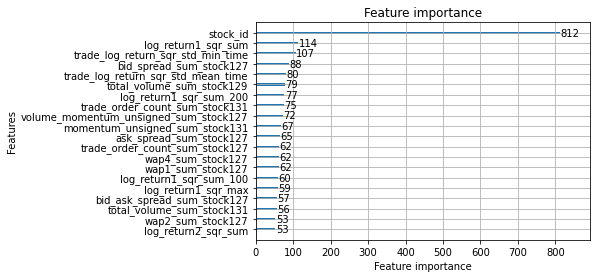

In [22]:
lgbtime = time.time()

# Define the custom metric to optimize
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate_lgb(train, test, params):
    
    features = [col for col in train.columns if col not in {"time_id", "target", "target_sqr", "row_id", 'is_train'}]
    y = train['target']
    
    y_train = np.zeros(train.shape[0])
    y_test = np.zeros(test.shape[0])
    
    kf = GroupKFold(n_splits=NFOLD)
    for fold, (trn_ind, val_ind) in enumerate(kf.split(train, y_target, time_id)):
        print('Fold:', fold)
        x_train, x_val = train.iloc[trn_ind], train.iloc[val_ind]
        y_tra, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        train_dataset = lgb.Dataset(x_train[features], y_tra, weight = (1. / (np.square(y_tra) + 1e-6)) )
        valid_dataset = lgb.Dataset(x_val[features], y_val)
        model = lgb.train(params = params,
                          num_boost_round=3000,
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, valid_dataset], 
                          verbose_eval = 100,
                          early_stopping_rounds=20,
                          feval = feval_rmspe)
        
        y_train[val_ind] = np.clip(model.predict(x_val[features]), 2e-4, 0.072)
        y_test += np.clip((model.predict(test[features])), 2e-4, 0.072)        
    y_test/=NFOLD
    
    print('LightGBM Rmspe Fold:', rmspe(y_target, y_train))
    lgb.plot_importance(model,max_num_features=20)
    
    return y_train, y_test


params = {
    'objective': 'rmse',
    'boosting_type': 'gbdt',
    'max_depth': -1,
    'max_bin':255,
    'min_data_in_leaf':750,
    'learning_rate': 0.05,
    'subsample': 0.72,
    'subsample_freq': 3,
    'feature_fraction': 0.5,
    'lambda_l1': 0.5,
    'lambda_l2': 1.0,
    'categorical_column':[0],
    'seed':2021,
    'n_jobs':-1,
    'verbose': -1,
    'device': 'gpu',
    'num_gpu': 1,
    'gpu_platform_id':-1,
    'gpu_device_id':-1,
    'gpu_use_dp': False,
}

y_train3, y_test3 = train_and_evaluate_lgb(train.to_pandas(), test.to_pandas(), params)
_= gc.collect()

print( 'LightGBM Rmspe CV:', rmspe(y_target, y_train3), 'time: ', int(time.time() - lgbtime), 's', y_test3[:3]   )

# Ensembling Time

In [23]:
print( 'LightGBM Rmspe:', rmspe(y_target, y_train3) )
print( 'XGBoost Rmspe:', rmspe(y_target, y_train1) )
print( 'CatBoost Rmspe:', rmspe(y_target, y_train2) )

LightGBM Rmspe: 0.21892936615106087
XGBoost Rmspe: 0.22291659855734947
CatBoost Rmspe: 0.22184073898626325


In [24]:
def minimize_arit(W):
    ypred = W[0] * y_train1 + W[1] * y_train2 + W[2] * y_train3
    return rmspe(y_target, ypred )

W0 = minimize(minimize_arit, [1./3]*3, options={'gtol': 1e-6, 'disp': True}).x
print('Weights arit:',W0)

Optimization terminated successfully.
         Current function value: 0.216723
         Iterations: 23
         Function evaluations: 100
         Gradient evaluations: 25
Weights arit: [0.1172443  0.21160872 0.64452596]


In [25]:
def signed_power(var, p=2):
    return np.sign(var) * np.abs(var)**p

def minimize_geom(W):
    ypred = signed_power(y_train1, W[0]) * signed_power(y_train2, W[1]) * signed_power(y_train3, W[2])
    return rmspe(y_target, ypred)

W1 = minimize(minimize_geom, [1./3]*3, options={'gtol': 1e-6, 'disp': True}).x

print('weights geom:',W1)

         Current function value: 0.216513
         Iterations: 26
         Function evaluations: 476
         Gradient evaluations: 115
weights geom: [0.13681704 0.21649332 0.65145041]


In [26]:
ypred0 = W0[0] * y_train1 + W0[1] * y_train2 + W0[2] * y_train3
print( np.min(ypred0), np.max(ypred0))

ypred1 = signed_power(y_train1, W1[0]) * signed_power(y_train2, W1[1]) * signed_power(y_train3, W1[2])
print( np.min(ypred1) , np.max(ypred1) )

print( 'Ensemble:', rmspe(y_target, np.clip((ypred0+ypred1)/2 ,0.0002, 0.071) ) )

0.00036092153001403515 0.02036468712865803
0.0003571056420813867 0.02055128115485962
Ensemble: 0.21661269724888246


In [27]:
print( np.min(ypred0),np.mean(ypred0),np.max(ypred0),np.std(ypred0) )
print( np.min(ypred1),np.mean(ypred1),np.max(ypred1),np.std(ypred1) )

0.00036092153001403515 0.0035054037151967476 0.02036468712865803 0.002369979073588085
0.0003571056420813867 0.003508673521200343 0.02055128115485962 0.0023855323180432203


(array([5.0600e+02, 1.9870e+03, 5.6940e+03, 1.2091e+04, 1.8320e+04,
        2.2033e+04, 2.5574e+04, 2.7084e+04, 2.5895e+04, 2.5015e+04,
        2.3966e+04, 2.1901e+04, 1.9961e+04, 1.8523e+04, 1.6770e+04,
        1.5271e+04, 1.3547e+04, 1.2134e+04, 1.0779e+04, 9.9160e+03,
        8.9600e+03, 8.0330e+03, 7.2740e+03, 6.3440e+03, 5.9240e+03,
        5.3170e+03, 4.8340e+03, 4.3880e+03, 3.8690e+03, 3.5510e+03,
        3.1930e+03, 3.0410e+03, 2.6720e+03, 2.6260e+03, 2.2340e+03,
        2.1330e+03, 1.9160e+03, 1.7890e+03, 1.6360e+03, 1.4630e+03,
        1.3890e+03, 1.3300e+03, 1.1450e+03, 1.1890e+03, 1.0990e+03,
        9.9100e+02, 9.3700e+02, 9.2200e+02, 8.1600e+02, 7.6400e+02,
        6.9500e+02, 7.0400e+02, 6.1200e+02, 5.6600e+02, 5.2000e+02,
        4.5600e+02, 5.0400e+02, 4.8200e+02, 4.4500e+02, 3.8100e+02,
        3.9000e+02, 3.3300e+02, 3.2100e+02, 3.0900e+02, 2.7400e+02,
        2.5400e+02, 2.3800e+02, 2.4900e+02, 2.0500e+02, 2.3400e+02,
        2.0700e+02, 2.0000e+02, 1.6900e+02, 1.50

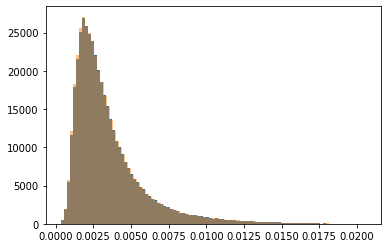

In [28]:
plt.hist(ypred0, bins=100)
plt.hist(ypred1, bins=100, alpha=0.5)

In [29]:
train['ypred'] = np.clip((ypred0+ypred1)/2 ,0.0002, 0.071)
train['error'] = (train['target'] - train['ypred']) / train['target']
train['error'] = train['error']**2

dt = train.groupby('stock_id')['error'].agg('mean').reset_index()
dt['error'] = np.sqrt(dt['error'])
dt = dt.sort_values('error', ascending=False)
dt.to_csv('error-contribution.csv', index=False)
del train['ypred'], train['error']
dt.head(10)

,stock_id,error
50,31,0.637885
1,37,0.290798
111,18,0.282427
26,33,0.276736
17,88,0.272762
28,60,0.268814
39,110,0.266686
18,81,0.259383
9,27,0.259048
57,80,0.256940


In [30]:
dt.tail(10)

,stock_id,error
99,61,0.170673
34,77,0.170498
74,10,0.169092
73,50,0.168778
94,35,0.168542
44,84,0.168212
100,96,0.162973
47,14,0.162926
85,124,0.162646
29,56,0.154537


In [31]:
ypred0 = W0[0] * y_test1 + W0[1] * y_test2 + W0[2] * y_test3
ypred1 = signed_power(y_test1, W1[0]) * signed_power(y_test2, W1[1]) * signed_power(y_test3, W1[2])

ypredtest = np.clip((ypred0+ypred1)/2,0.0002, 0.071)
print( ypred0[:3],  ypred1[:3], ypredtest[:3] )

test['target'] = ypredtest
test[['row_id', 'target']].to_csv('submission.csv',index = False)
test[['row_id', 'target']].head(3)

[0.00142856 0.00628811 0.00628811] [0.00118801 0.00187841 0.00187841] [0.00130829 0.00408326 0.00408326]


,row_id,target
0,0-4,0.001308
1,0-32,0.004083
2,0-34,0.004083
